# Homework 3 - Grossrieder, 301436

In this homework, we are going to work with the transformer. There are three parts of this homework.

- In the first part, we are going to implement **positional encoding** and **self-attention**  and test them on a simple text dataset which contains around 100 sentences. We will use a small transformer in this task.

- In the second part, we will detect promoters from the DNA sequences. The main difference compared to the previous task is to tokenize the DNA sequence. Thus, our task here is to build the **tokenizer** to tokenize the DNA sequence. For the model, we will continue using the small transformer.

- In the third part, we will use a **foundation model** DNABERT to perform promoter detection. In this part, you do not need to train the transformer. Instead, you need to find and load the correct pre-trained model and then use it to get the embedding of the DNA sequence. Then, you will build a simple classifier to perform promoter detection based on the DNA embedding.



__________________________________________
before the start we add few libraries that are useful (especially for the third part)


I got a lot of issue with the error : "The model class you are passing has a config_class attribute that is not consistent with the config class you passed ...". Even with the methods mentionned below I couldn't solve the issue so this small part of the code is here to instal a previous version of Transformersand that is compatible with the model and solve the issue. **Ensure that it is the transformers version 4.29.0 because the part 3 will not work if it is not the case.**

In [1]:
import subprocess
import pkg_resources


# Uninstall the current version of transformers
subprocess.run(["pip", "uninstall", "-y", "transformers"])
# Install transformers version 4.29
subprocess.run(["pip", "install", "transformers==4.29"])

# Get the version of the transformers library
transformers_version_before = pkg_resources.get_distribution("transformers").version
print(f"Transformers version: {transformers_version_before}")

C:\Users\gross\AppData\Local\Temp\ipykernel_15792\852396659.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Transformers version: 4.29.0


In [2]:
#libraries for cleaning outputs
from IPython.display import clear_output

 I will be using my CPU for this homework. Therefore I will strongly reduce the dataset size to be able to run the code in a reasonable time. Especially for the third part, where I got an incompatibility issue with the cuda while not using a CPU. :( In any case I do not have any GPU on my computer so I does not really matter. ^^'

In [3]:
# we define a debug mode
debug_mode = True

**REMARK : SOME OF THE ORIGINAL CODE HAVE BEEN SLIGHTLY MODIFIED TO RUN IN A MUCH LESS TIME WITH DEBUG MODE TURNED ON !**


__________________________________

## 0. Initialization

Import the packages you are going to use here.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import random
import numpy as np
from torchmetrics.classification import BinaryF1Score

import ipywidgets as widgets
from types import SimpleNamespace
from utils import data, evaluation, models, visualization, text_exercise

import math

Set the hyperparameters.

In [5]:
# Set seeds
seed = 128
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Positional Encoding and Self-Attention (7 pts)

### 1.1. Sinusoidal Positional Encoding (1 pt)

In this section, you are going to implement the sinusoidal positional encoding. The formula is as the following:

<div>
<img src="./imgs/positional embedding.png" width="400"/>
</div>

where $t$ is the desired position in the input and $\mathsf{\omega}_k$ follows:

<div>
<img src="./imgs/omega.png" width="200"/>
</div>

To see the details of sinusoidal positional encoding, you can check this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [6]:
class PositionalEmbedding(nn.Module):

    def __init__(self, max_position_embeddings, hidden_size, device):
        super().__init__()

        '''
        max_position_embeddings: maximum length of the input - related to t in the previous formula
        hidden_size: encoding dimension - d in the previous formula
        '''

        # ToDo: implement positional embedding
        # Hint: follow the previous formula
        
        # Store positional embedding parameters
        self.max_position_embeddings = max_position_embeddings
        self.hidden_size = hidden_size
        self.device = device

        # Compute positional encodings
        # tensor with values from 0 to max_position_embeddings - 1 + reshape to [max_position_embeddings, 1]
        position = torch.arange(max_position_embeddings).unsqueeze(1)
        # define w_i = 1/(10000)^(2i/d)
        div_term = torch.exp(torch.arange(0., hidden_size, 2) * -(np.log(10000.0) / hidden_size))#  exp(-i/hidden_size*log(10000)) = 10000^(-i/hidden_size)

        #  Compute sine and cosine components separately
        pos_enc = torch.zeros(max_position_embeddings, hidden_size) #initialize tensor with zeros
        pos_enc[:, 0::2] = torch.sin(position * div_term) #  [max_position_embeddings, hidden_size/2] -> only even columns
        pos_enc[:, 1::2] = torch.cos(position * div_term) #  [max_position_embeddings, hidden_size/2] -> only odd columns


        #  transform from an old instance to a brand new parameter of the mode
        self.positional_embedding = nn.Parameter(pos_enc, requires_grad=False)

        
        
    def forward(self, x):
        return self.positional_embedding
    
    def embedding(self):
        print(self.positional_embedding.dtype)
        return self.positional_embedding

Here, you can visualize your positional encoding. If you implement everything correctly, you can get a figure that is similar to Figure 2 in this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [7]:
visualize_embedding, dimension_selector, max_len_selector = visualization.display_positional_encoding(PositionalEmbedding)
ui = widgets.HBox([max_len_selector, dimension_selector])  
out = widgets.interactive_output( visualize_embedding, {'max_len': max_len_selector, 'dimension': dimension_selector})
display(ui, out)

Output()

### 1.2. Self-Attention Mechanism (5 pts)

In this section, you are going to implement the self-attention mechanism. Please check the section 'Self-Attention in Detail' in this [link](https://jalammar.github.io/illustrated-transformer/) for the details of self-attention mechanism. (We encourage you to carefully go through the link since it is a very good tutorial for transformer.)

The specific steps will be provided in the comments of the following code. (The steps are only for reference. You do need to follow the steps if you have a better way to implement it.)

In [8]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )
        self.output_attentions = config.output_attentions
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # ToDo: initialize K, Q, V 
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        
        # ToDo: add a dropout layer
        # Hint: using config.attention_probs_dropout_prob as the dropout probability
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        # The parameter encoder_hidden_states and encoder_attention_mask is for cross-attention. 
        # We do not use them in this homework.

        # ToDo: get the key, query, and value from the hidden_states
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)
        
        mixed_query_layer = self.query(hidden_states)

        # ToDo: transpose K, Q, V to get the score
        # Hint: using self.transpose_for_scores
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # ToDo: Get the raw attention score
        # Hint: Lecture 05 transformers - Slide 23 - the part within the softmax
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) # Matmul : Q and K
        attention_scores = attention_scores / math.sqrt(self.attention_head_size) # Scale : sqrt(d_k)
                
        # You do not need to change this part.
        # Explanation of attention_mask: https://lukesalamone.github.io/posts/what-are-attention-masks/
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # ToDo: Normalize the attention scores to probabilities.
        # Hint: 
        # 1. Lecture 05 transformers - Slide 23 - using softmax to get the probability
        # 2. Use self.dropout to do the dropout
        attention_probs = nn.Softmax(dim=-1)(attention_scores) # WG add : Softmax
        attention_probs = self.dropout(attention_probs)

        # You do not need to change this part.
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        # ToDo: Multiply each value by the score
        # Hint: 
        # 1. Lecture 05 transformers - Slide 23 - getting the final result
        # 2. Permuting the result to the correct shape. If you do not know what should be the correct shape, you can print the shape of the tensors.
        context_layer = torch.matmul(attention_probs, value_layer) # Matmul : Softmax() and V
        # method changes the order of the dimensions
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous() #( ensure that the data is stored contiguously in memory)  
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)# keep the first two dimesion and add the all_head_size dimension
        #reshape the tensor
        context_layer = context_layer.view(*new_context_layer_shape)
        
        # Get the output
        outputs = (context_layer, attention_probs) if self.output_attentions else (context_layer,)
        return outputs

Let's test your implementation using simple text data! First, let's load the data.

We use a small dataset in this homework for a shorter training time.

In [9]:
# ChatGPT generated text data about BERT
text = text_exercise.get()
sentences_df, vocab = data.to_sentence_df(text)

After loading the data, you can train your model. Here we train our model using masked token prediction.

Hint: The final model accuracy should be higher than 0.9.

In [10]:
text_max_len = 11

text_config = SimpleNamespace(
        vocab_size=len(vocab),
        hidden_size=60,
        max_position_embeddings=text_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=1,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=1,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=False,
        pruned_heads = {},
        initializer_range=0.02,
        device="cpu"
    )

tokenizer = data.TextTokenizer(vocab)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(sentences_df, tokenizer, k=1, max_len=text_max_len, noise_rate=0.4)

model = models.BertForMaskedLM(config=text_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

for epoch in range(200):
    optimizer.zero_grad()
    loss, outputs, attentions = model(
        input_ids=input_ids,
        token_type_ids=segment_ids,
        masked_lm_labels=masked_lm_labels,
        attention_mask=attention_masks
    )
    if (epoch + 1) % 20 == 0:
        clear_output(wait=True)
        print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

print(f"Final model accuracy: {evaluation.masked_label_accuracy(labels, labels_idx, outputs.data)}")

Epoch: 0200 loss = 0.415548
Final model accuracy: 1.0


### 1.3. Visualize Attention (1 pt)

Here, you can visualize the self-attention. 

Question: Can you interpret the visualization of the self-attention?

**Write down you answer here (1 pt):**

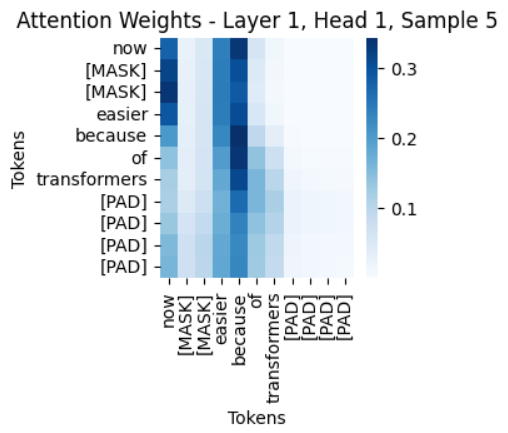


WG answer : Depending on the training time we might get different result. So here is one of them (in debug mode turned on) The visualisation shows the importance of a word related to another one. On the x-axis we have the word that we are analysing and on the y-axis the word that we are comparing it to. The darker the color is, the more important the word. We can see that the word "[MASK2]" (y-axis) is very important link for the word "now" (x-axis) as the value is larger than the other one. This mean that the word is important to understand the meaning of the word "now". At contrary the word "[MASK2]" (y-axis) is not important to understand the word "transformers"(x-axis) as the value is very low. Probably because the word "transformer" is understanable by itself with less context than the word "now".

In [11]:
visualize_attention, sample_id_selector = visualization.display_attantion(attentions=attentions, input_ids=input_ids, tokenizer=tokenizer)
widgets.interactive(visualize_attention, sample_id=sample_id_selector)

interactive(children=(Dropdown(description='Sample:', options=(5, 8, 11, 13, 18, 24, 26, 29, 31, 35, 37, 38, 6…

### 1.4. Train on small Wikitext Dataset

Here, you can **optionally** test your model on the smallest wikitext dataset. You should get an test accuracy around 0.4 after training 50 epochs.

This part is only for you to test your code. You can choose to run it or not. It takes around 1 hour to train the model for 50 epochs on the smallest wikitext dataset with Google Colab.

In [12]:
#text_exercise.train_wikitext(device, positional_embedding=PositionalEmbedding, attention=BertSelfAttention)

Here is the image after the 10 epochs trainig on the smallest wikitext dataset.
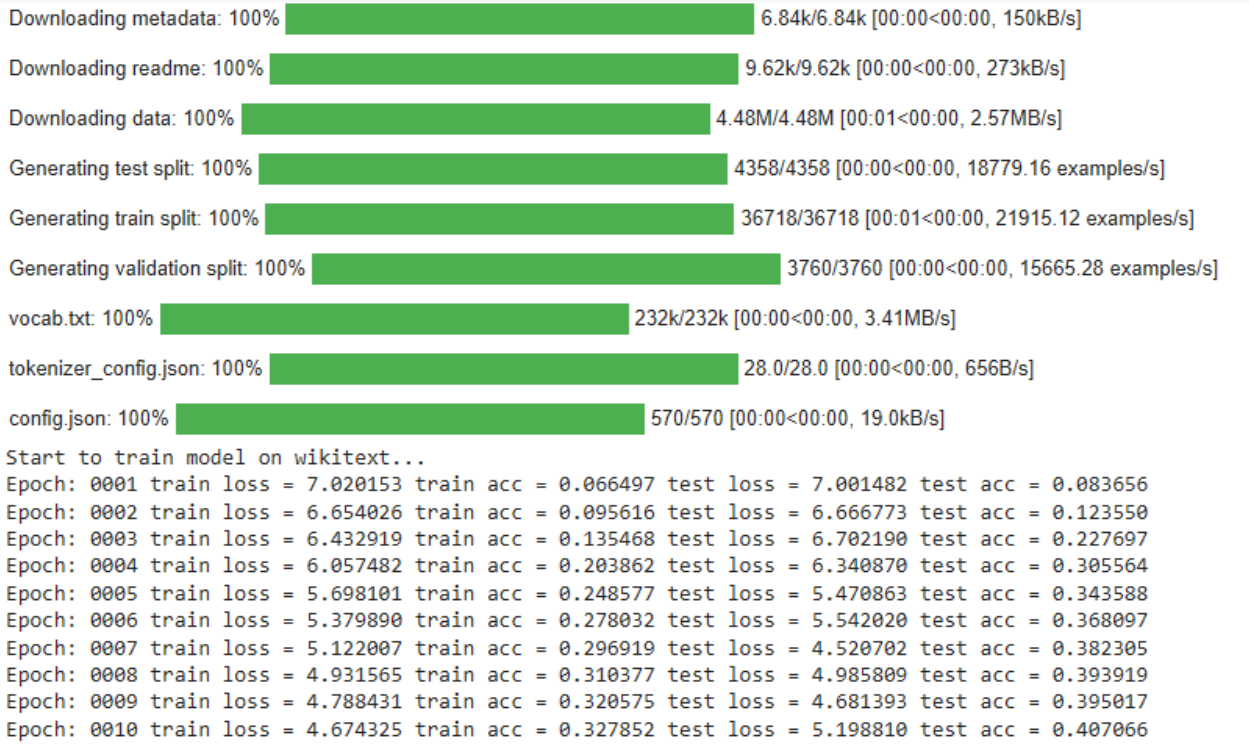

In [13]:
#clear memory to make it available for the next steps
torch.cuda.empty_cache()

## 2. Promoter detection (7 pts)

In this section, we detect promoter in DNA sequence.

A promoter is a region of DNA upstream of a gene where relevant proteins (such as RNA polymerase and transcription factors) bind to initiate transcription of that gene. Promoter detection is to identify if there are promoter regions in the given DNA sequence. We have covered this in the lecture. (If you are interested in the promoter, you can check this [link](https://www.genome.gov/genetics-glossary/Promoter) for more details.)

Here, we use a transformer and a classifier. The transformer first embeds the DNA sequences into features, and then the classifier detects the promoter based on the features.

The main difference between text and DNA sequence is how to tokenize the sequence. Thus, you need to implement a tokenizer for the DNA sequence.

### 2.1. DNA Tokenizer (1 pts)

Here, you will implement the DNA tokenizer the same as in DNABERT. Please check this [paper](https://academic.oup.com/bioinformatics/article/37/15/2112/6128680) for implementation details. Also, you need to check the data type and shape for both input and output.

In [14]:
class DNATokenizer(data.Tokenizer):
    def __init__(self, k, vocab, unknown="[UNK]"):
        super().__init__(vocab, unknown)

        # self.k is the k of k-mers
        self.k = k
        self.vocab = vocab
        self.unknown = unknown

    def _parse_text(self, text):
        # Initialize an empty list for tokens
        tokens = []

        # Iterate over the DNA sequence to create k-mers
        for i in range(len(text) - self.k + 1):
            k_mer = text[i:i+self.k] #no stride
            tokens.append(k_mer)

        # Replace tokens not in vocabulary with the unknown token
        output = []
        for token in tokens:
            if token in self.vocab:
                output.append(token)
            else:
                output.append(self.unknown)

        return output
        

### 2.2. Test BERT on DNA Sequence

In this section, you will train BERT on DNA sequence to learn the embedding of DNA sequence. The code is provided below and you do not need to write anything.

Hint: the final evaluation accuracy should be higher than 0.2.

In [15]:
kmer = 3
mask_length = kmer
VOCAB_3MER = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "AAA", "AAT", "AAC", "AAG", "ATA", "ATT", "ATC", "ATG", "ACA", "ACT", "ACC", "ACG", "AGA", "AGT", "AGC", "AGG", "TAA", "TAT", "TAC", "TAG", "TTA", "TTT", "TTC", "TTG", "TCA", "TCT", "TCC", "TCG", "TGA", "TGT", "TGC", "TGG", "CAA", "CAT", "CAC", "CAG", "CTA", "CTT", "CTC", "CTG", "CCA", "CCT", "CCC", "CCG", "CGA", "CGT", "CGC", "CGG", "GAA", "GAT", "GAC", "GAG", "GTA", "GTT", "GTC", "GTG", "GCA", "GCT", "GCC", "GCG", "GGA", "GGT", "GGC", "GGG" ]

raw_training_data = data.load_csv("./data/train.csv")
raw_test_data = data.load_csv("./data/test.csv")

dna_max_len = 298
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
if debug_mode:
  dataset_size = 200

num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
        vocab_size=len(VOCAB_3MER),
        hidden_size=60,
        max_position_embeddings=dna_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=num_heads,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=num_layers,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=True,
        pruned_heads = {},
        initializer_range=0.02,
        device=device
    )

tokenizer = DNATokenizer(k=kmer, vocab=VOCAB_3MER)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(raw_training_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = data.generate_masked_data(raw_test_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)

model = models.BertForMaskedLM(config=dna_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.002)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

train_dataset = TensorDataset(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 50
if debug_mode:
    num_epochs = 3

for epoch in range(num_epochs):
  total_train_loss = 0
  model.train()
  
  i = 0 # for debug
  for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in train_loader:
    optimizer.zero_grad()
    loss, outputs, hidden_states, _ = model(
        input_ids=batch_input_ids.to(device),
        token_type_ids=batch_segment_ids.to(device),
        masked_lm_labels=batch_masked_lm_labels.to(device),
        attention_mask=batch_attention_mask.to(device)
    )
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()
    i += 1
    if debug_mode and i > 5:
      break
  avg_train_loss = total_train_loss / len(train_loader)

  if debug_mode:
    test_statement = (epoch + 1) % 3 == 0
  else:
    test_statement = (epoch + 1) % 10 == 0
    
  if test_statement:
    model.eval()
    total_eval_loss = 0
    j = 0 # for debug
    for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in test_loader:
      with torch.no_grad():
        loss, outputs, hidden_states, _ = model(
          input_ids=batch_input_ids.to(device),
          token_type_ids=batch_segment_ids.to(device),
          masked_lm_labels=batch_masked_lm_labels.to(device),
          attention_mask=batch_attention_mask.to(device)
        )
        if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0 :
          print("found patting", batch_attention_mask.sum())
        total_eval_loss += loss.item()
        
        if debug_mode and j > 3:
          break
    avg_eval_loss = total_eval_loss / len(test_loader)
    print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss))

average_train_acc, _ = evaluation.model_masked_label_accuracy(model, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(model, test_loader, device)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))

Number of trainable model parameters: 136749
Epoch: 0010 train cost = 4.017668 eval cost = 4.066977
Epoch: 0020 train cost = 3.854006 eval cost = 3.990573
Epoch: 0030 train cost = 3.247562 eval cost = 3.409278
Epoch: 0040 train cost = 2.916055 eval cost = 3.227208
Epoch: 0050 train cost = 2.420712 eval cost = 2.758669
Train Acc = 0.263447 Eval Acc = 0.180364


### 2.3. Visualize the Attentions (1 pt)

Here, you can visualize the self-attention. 

Question: compare the visualization to Section 1.3, what can you find here? How do you explain it?

**Write down you answer here (1 pt):**

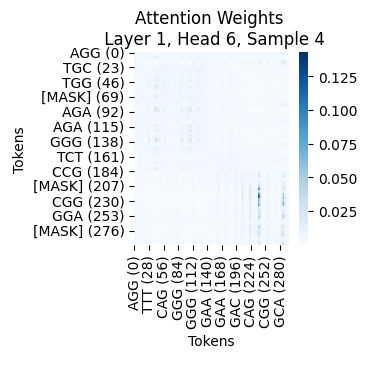

Image with debug_mode = off

The first things that we notice is that the accuracy is very low we only have an accuracy of 0.2. Secondly  we can see from the attention weights matrix is that most of the attention weights are very low meaning that the tokens do not depend on each other except at some few points where the attention weights seems higher this could potentially mean that in these regions we could have an important feature like a promoter on an enhancer, While the other parts of the attention weight matrix is low suggesting that we have no important features in this regions. Therefore showing a higher dependencies between each tokens. Does generally search sequence are not depending on only 3 nucleis acids but on a larger sequence of nucleis acids.

note : variation can occur if the debugmode is turned on or off.

In [16]:
visualize_attention, sample_id_selector, layer_selector, head_selector = visualization.display_multi_attantion(attentions=last_test_attention, tokenizer=tokenizer, input_ids=input_ids,  layers=range(1, num_layers+1),  heads=range(1, num_heads+1))
ui = widgets.HBox([sample_id_selector, layer_selector, head_selector])  
out = widgets.interactive_output(visualize_attention, {'sample_id': sample_id_selector, 'layer': layer_selector, 'head': head_selector})
display(ui, out)

Output()

### 2.4. Use your pretrained model for promoter detection (5 pts)

You already have the embeddings for the DNA sequence. Now, you are going to build a classifier based on the DNA embeddings. The classifier is to perform promoter detection. Specifically, the DNA sequence will be classified into *'contains promoter'* or *'does not contain promoter'*.

Hint: 
- We now want to annotate data (get the label for each sample), not predict masked data anymore!
- You can reuse some parts of the code in the previous sections, e.g. dataloader and training pipeline in Section 2.2.
- If you implement the previous section correctly (the Eval Acc > 0.2 in Section 2.2), you already have an pre-trained object named 'model' of class models.BertForMaskedLM. You can directly use it.
- The evaluation accuracy of this task should be around 0.6.

In [17]:
# ToDo: Define the classifier
# Hint: We need only a binary classifier
class BinaryClassifier(nn.Module):
    def __init__(self,model):
        super(BinaryClassifier, self).__init__()
        #save the model
        self.bert = model
        #get the hidden size of the last layer
        size = self.bert.config.hidden_size
        #define the network : the architecture of the classifier is purely arbitrary
        self.classifier = nn.Sequential(
            nn.Linear(size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            )

    def forward(self, input_ids, token_type_ids, masked_lm_labels, attention_mask):
        _, _, hidden_states, _ = self.bert(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            masked_lm_labels=masked_lm_labels,
            attention_mask = attention_mask
        )
        # find the last hidden state
        last_hidden_state = hidden_states[-1]
        #pooling across the tokens in the sequence
        mean_pooling = torch.mean(last_hidden_state, dim=1)
        return self.classifier(mean_pooling)


# ToDo: Freeze BERT parameters
# Hint: 
# 1. BERT is the 'model' you have trained in Section 2.2.
# 2. Check Exercise 1 to see how to freeze a model (set requires_grad to False)
# Initialize the classifier
classifier = BinaryClassifier(model)

# ToDo: Freeze model parameters
for param in classifier.bert.parameters():
    param.requires_grad = False

# ToDo: Train your classifier
# Hint: 
# 1. Write the training pipeline (dataloader, optimizer, training loop ...)
# 2. You can reuse the code from Section 2.2.

#find the labels and restrict to the dataset size
labels_test = np.array(raw_test_data["label"])[:dataset_size]
labels_train = np.array(raw_training_data["label"])[:dataset_size]

#define the optimizer & loss function
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

# Accuracy calculation initialization
correct_predictions = 0
total_predictions = 0
total_train_loss = 0

# Define the number of epochs
num_epochs = 10  
if debug_mode:
    num_epochs = 3
    

for epoch in range(num_epochs):
    classifier.train()  # Set the model to training mode
    j = 0 # for batch labels indexing
    i = 0 # for debug
    for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in train_loader:
        #set the gradients to zero before starting to do backpropragation
        optimizer.zero_grad()
        
        #set no masking
        batch_masked_lm_labels.fill_(-100)
        
        #find the corresponding labels
        batch_labels = torch.tensor(labels_train[j*batch_size:(j+1)*batch_size]).float()
        j+=1
        
        #forward pass
        classifier_output = classifier(
            input_ids=batch_input_ids.to(device),
            token_type_ids=batch_segment_ids.to(device),
            masked_lm_labels=batch_masked_lm_labels.to(device),
            attention_mask=batch_attention_mask.to(device)
        ).squeeze()

        #backward pass        
        loss = criterion(classifier_output, batch_labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        
        i+=1        
        if debug_mode and i > 3:
            break

    avg_train_loss = total_train_loss / len(train_loader)


    # set different condition for the entry of the loop depending on the debug mode
    if debug_mode:
        test_statement = (epoch + 1) % 3 == 0
    else:
        test_statement = (epoch + 1) % 10 == 0
        
    # Test the model
    if test_statement:
        classifier.eval()
        total_eval_loss = 0
        k = 0 # for batch labels indexing
        
        with torch.no_grad():
            for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in test_loader:
                # set no masking
                batch_masked_lm_labels.fill_(-100)

                #forward pass
                classifier_output = classifier(
                    input_ids=batch_input_ids.to(device),
                    token_type_ids=batch_segment_ids.to(device),
                    masked_lm_labels=batch_masked_lm_labels,
                    attention_mask=batch_attention_mask.to(device)
                ).squeeze()
                
                #find the corresponding labels                
                batch_labels = torch.tensor(labels_test[k*batch_size:(k+1)*batch_size]).float()
                k+=1
                
                # convert the output to binary labels
                predicted_labels = (classifier_output > 0.5).float()
                
                # Compute the accuracy
                correct_predictions += (predicted_labels == batch_labels).sum().item()
                total_predictions += len(batch_labels)
            
                # Compute the loss
                total_eval_loss += loss.item()
        
        # Compute the average loss
        avg_eval_loss = total_eval_loss / len(test_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

print(f'Test Accuracy: {correct_predictions / total_predictions}')

Epoch 10/10, Loss: 0.6896677017211914
Test Accuracy: 0.488


We got a accuracy which is lower than the expected value of 0.6. We only have 0.55 (in debug mode)

### 2.5. Additional question (1 pt)

Now we change mask_length = 1 (already changed, you do not need to implement anything).
Let's run the code below and check the accuracy.

Question: What is the final masked token prediction accuracy? How do you explain this?

**Write down you answer here (1 pt):**

The accuracy is very large in comparison to the previous one. This is because we are only masking one token and not the whole sequence. Therefore the model is able to predict the masked token with a very high accuracy. Howeveras we have seen during the course of week 6 slide 13. Music only one token is very easy for the model to predict as if he has seen something similar it can very easy predict. Therefore The network is not learning interesting features. So yes it has an high prediction accuracy but it is not learning features we are aiming to learn.


In [18]:
kmer = 3
mask_length = 1

dna_max_len = 298
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
if debug_mode:
  dataset_size = 200
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
        vocab_size=len(VOCAB_3MER),
        hidden_size=60,
        max_position_embeddings=dna_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=num_heads,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=num_layers,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=True,
        pruned_heads = {},
        initializer_range=0.02,
        device=device
    )

tokenizer = DNATokenizer(k=3, vocab=VOCAB_3MER)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(raw_training_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)
test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = data.generate_masked_data(raw_test_data, tokenizer, max_len=dna_max_len, max_mask=max_dna_mask, k=mask_length, mask_rate=0.05, max_size=dataset_size)

model = models.BertForMaskedLM(config=dna_config, positional_embedding=PositionalEmbedding, attention=BertSelfAttention).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.002)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

train_dataset = TensorDataset(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 50
if debug_mode:
    num_epochs = 3

for epoch in range(num_epochs):
  total_train_loss = 0
  model.train()
  i=0 # for debug
  for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in train_loader:
    optimizer.zero_grad()
    loss, outputs, hidden_states, _ = model(
        input_ids=batch_input_ids.to(device),
        token_type_ids=batch_segment_ids.to(device),
        masked_lm_labels=batch_masked_lm_labels.to(device),
        attention_mask=batch_attention_mask.to(device)
    )
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()
    
    i += 1
    if debug_mode and i > 5:
      break
    
  avg_train_loss = total_train_loss / len(train_loader)

  if debug_mode:
    test_statement = (epoch + 1) % 3 == 0
  else:
    test_statement = (epoch + 1) % 10 == 0
    
  if test_statement:
    model.eval()
    total_eval_loss = 0
    j=0 # for debug
    for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in test_loader:
      with torch.no_grad():
        loss, outputs, hidden_states, _ = model(
          input_ids=batch_input_ids.to(device),
          token_type_ids=batch_segment_ids.to(device),
          masked_lm_labels=batch_masked_lm_labels.to(device),
          attention_mask=batch_attention_mask.to(device)
        )
        if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0 :
          print("found patting", batch_attention_mask.sum())
        total_eval_loss += loss.item()
        if debug_mode and j > 3:
          break
    avg_eval_loss = total_eval_loss / len(test_loader)
    print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss))

average_train_acc, _ = evaluation.model_masked_label_accuracy(model, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(model, test_loader, device)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))

Number of trainable model parameters: 136749
Epoch: 0010 train cost = 4.007698 eval cost = 4.073000
Epoch: 0020 train cost = 3.743280 eval cost = 3.886551
Epoch: 0030 train cost = 2.801623 eval cost = 2.945738
Epoch: 0040 train cost = 1.309114 eval cost = 1.381033
Epoch: 0050 train cost = 0.461658 eval cost = 0.628868
Train Acc = 0.939512 Eval Acc = 0.919933


In [19]:
#clear memory to make it available for the next steps
torch.cuda.empty_cache()

## 3. Using foundation model (5 pts)

### 3.1. Introduction

In this section, we aim to use a foundation model, DNABERT, to perform promoter detection.
A foundation model is a model pretrained on large datasets. Foundation models serve as the foundational building blocks upon which various applications can be constructed.

Here, we use DNABERT as the foundation model. We first apply it on DNA sequence to get the embedding. Then, we train a classifier on the embedding as in Section 2. Please follow this [link](https://github.com/Zhihan1996/DNABERT_2) to load the foundation model.

### 3.2. Implementation

**Consider this situation:** You get a dataset about promoter detection, and you build your model to perform the task as in Section 2. However, the performance is not good since the model is not strong enough. Suddenly, you think we can use a large pre-trained model to embed DNA sequences. Then, you search online and find the pre-trained model [DNABERT](https://github.com/Zhihan1996/DNABERT_2). Now, you want to perform promoter detection using the pre-trained DNABERT.

There is no coding framework in this section. Just make things work (get good test accuracy) using the pre-trained model!

Hint: 
- We encourage you to create a **new environment** following the instructions of Section 3 in this [link](https://github.com/Zhihan1996/DNABERT_2). (When you face the error "The model class you are passing has a config_class attribute that is not consistent with the config class you passed ...", creating a new environment can save you.)
- Section 4 in this [link](https://github.com/Zhihan1996/DNABERT_2) shows you how to load and use the pre-trained foundation model.

a. Load the dataset.

In [20]:
# ToDo: Load the train and test datasets from train.csv and test.csv
# Hint: check Section 2.2.
#load the data
training_data = data.load_csv("./data/train.csv")
test_data = data.load_csv("./data/test.csv")

if debug_mode :
    
    training_data = training_data.sample(frac=0.01)
    test_data = test_data.sample(frac=0.01)

b. Get the embeddings of the DNA sequences using pretrained model.

Hint: 
- This step can take some time. Thus, you can start with a small sample size, and then increase it when you have made sure that everything works correctly.
- After getting the embeddings, you can save them so that you can directly load them next time without running the foundation model.

In [21]:
# ToDo: Load the pretrained DNABERT model and use this to get the embeddings of the train and test DNA sequences.
# Hint: Check section Quick Start on https://github.com/Zhihan1996/DNABERT_2

# define the labels and the sequences for training set
dna_sequences = training_data['sequence']
labels = training_data['label']


# load the tokenizer and the model
auto_tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
auto_model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)


# Tokenize and get embeddings
embeddings = []
for sequence in dna_sequences:
    # Tokenize the sequence
    inputs = auto_tokenizer(sequence, return_tensors="pt", add_special_tokens=True)
    #get the output and the loss
    loss, outputs = auto_model(**inputs)
    embeddings.append(outputs.detach().numpy())  # Detach and convert to numpy if needed

embeddings_before = embeddings

C:\Users\gross/.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\1d020b803b871a976f5f3d5565f0eac8f2c7bb81\bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to b

In [22]:
# reshape the embeddings
embeddings = torch.tensor(np.array(embeddings_before))
embeddings = embeddings.squeeze(1)

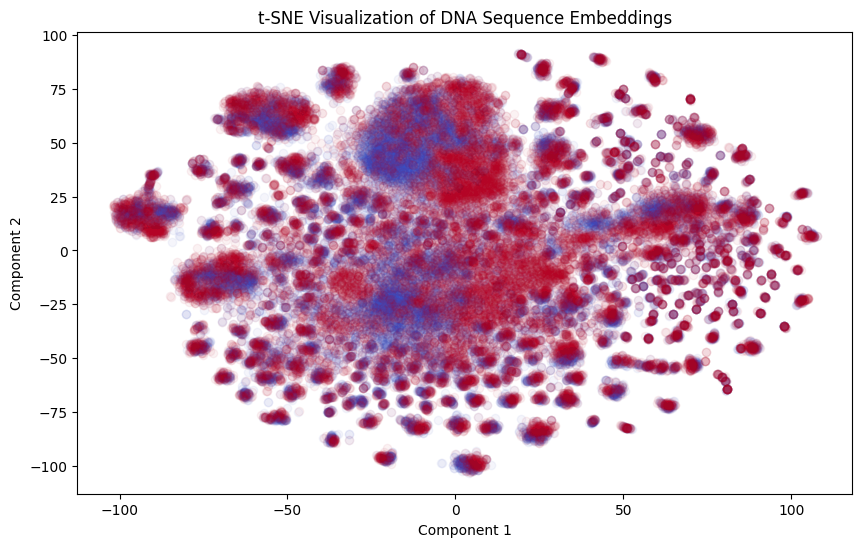

In [32]:
# ToDo: Using tsne or umap to visualize the embedding space.
# Hint: you can import other packages here for visualization.

# libraries for part 3
import sklearn as sk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from umap import UMAP  # Import UMAP from the umap-learn library

# Define the tsne model
tsne = TSNE(n_components=2)
#tsne = TSNE(n_components=2, random_state=42)

# reduce the dimension of the embeddings
reduced_embeddings = tsne.fit_transform(embeddings)

# Create a scatter plot with different colors for each label
unique_labels = np.unique(labels)
colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_labels)))


# Plot
plt.figure(figsize=(10,6))
for i, label in enumerate(unique_labels):
    # if label belongs to the class, mask is true
    mask = (labels == label)
    plt.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1], label=f'Label {label}', color=colors[i], alpha=0.05)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization of DNA Sequence Embeddings')
plt.show()


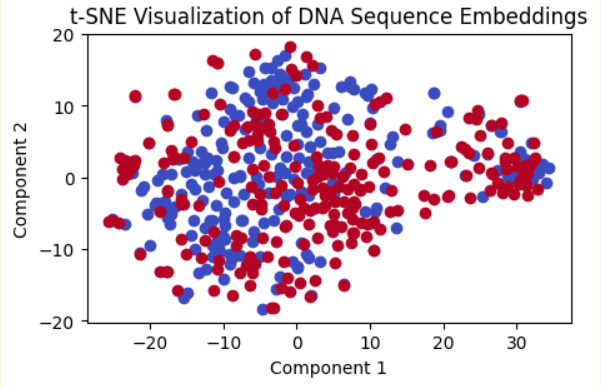

Here we have the visualisation with the debug mode turned on. So we have no clear separation. This is expected has the data set used for the debug mode is very small

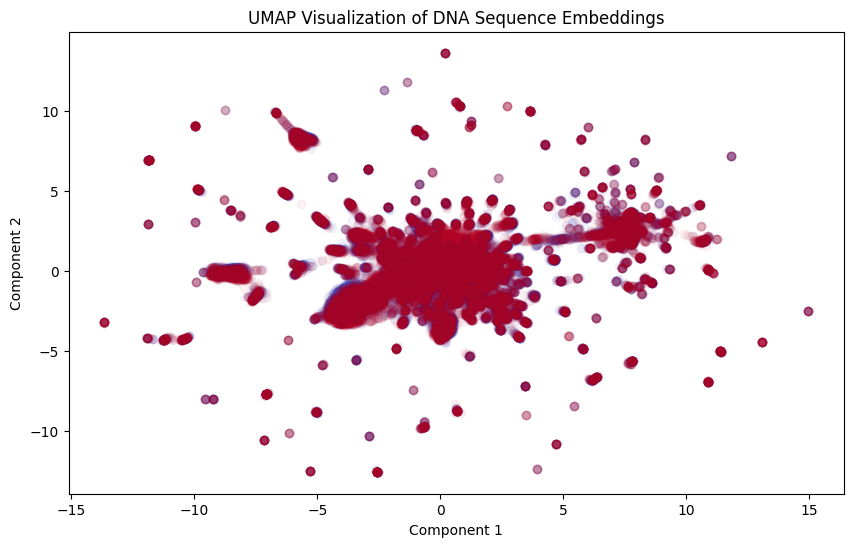

In [33]:
# Define the model
umap = UMAP(n_components=2)
# reduce the dimension of the embeddings
reduced_embeddings = umap.fit_transform(embeddings)

# Create a scatter plot with different colors for each label
unique_labels = np.unique(labels)
colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_labels)))

# Plot
plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    # if the label belongs to the class, mask is true
    mask = (labels == label)
    plt.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1], label=f'Label {label}', color=colors[i], alpha = 0.05)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('UMAP Visualization of DNA Sequence Embeddings')
plt.show()

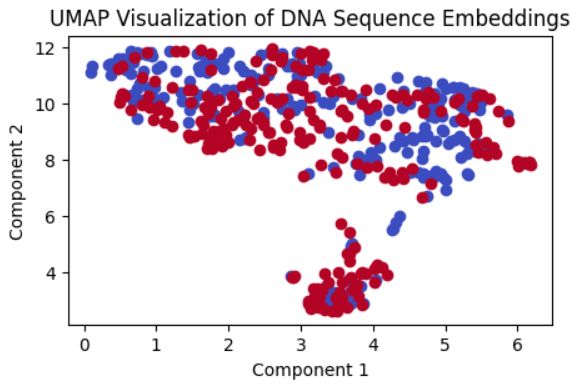

Similarly for the UMAP, the result is bad. But this is probably because I am not using the full dataset

c. Train a classifier.

Hint: It is easy to overfit on the training set. Try to avoid overfitting.

To avoid overfitting, I implemented a 4-fold cross-validation, a regularisation with an L2 norm, and a droupout. Which was the easiest to implement as they do not need more computation time like the data augmentation does or lots of validation calculations like early stopping requieres.

In [34]:
# ToDo: Define your classifier

class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.2):
        super(BinaryClassifier, self).__init__()
        #Define the MLP
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 1),
        )
    
    def forward(self, x):
        x = self.classifier(x)
        return x

In [49]:
# ToDo: Train your classifier
# Convert embeddings and labels to PyTorch tensors
X = torch.tensor(embeddings).float()
y = torch.tensor(labels.to_numpy()).float()

# Get the total number of samples
total_samples = X.size(0)

# Set the number of folds
Number_of_folds = 4

# Define fold size
fold_size = total_samples // Number_of_folds

# Initialize model, loss function, and optimizer for each fold
model = BinaryClassifier(embeddings.shape[1], embeddings.shape[1], dropout_rate=0.3)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00007, weight_decay=5e-2) #penality for large weights


# Cross-validation training loop
for fold in range(Number_of_folds):
    # Clear the output of the cell
    clear_output()
    # Show the current fold
    print(f'Fold {fold + 1}')

    # Define starting point and end point of the validation set
    val_start = fold * fold_size
    val_end = val_start + fold_size
    indices = np.arange(total_samples)
    
    # Generate indices for training and validation sets
    val_indices = indices[val_start:val_end]
    train_indices = np.concatenate([indices[:val_start], indices[val_end:]])

    # Create TensorDataset for train and validation
    train_dataset = TensorDataset(X[train_indices], y[train_indices])
    val_dataset = TensorDataset(X[val_indices], y[val_indices])

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    # Define the number of epochs
    num_epochs = 20
    if debug_mode:
        num_epochs = 3
    
    # Training loop for each fold
    for epoch in range(num_epochs):
        model.train() # set the model to training mode
        i = 0 # for debug
        for inputs, targets in train_loader:
            # Forward pass : get outputs and loss
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)

            # Backward and update the parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if debug_mode and i > 3:
                break


        # Validation for each fold
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, targets in val_loader:
                outputs = model(inputs).squeeze()
                predicted = outputs.round()
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
            print(f'Epoch [{epoch+1}/{num_epochs}], Fold {fold + 1}, Validation Accuracy: {correct / total}')

Fold 4
Epoch [1/20], Fold 4, Validation Accuracy: 0.39741532224005405
Epoch [2/20], Fold 4, Validation Accuracy: 0.44927781062589744
Epoch [3/20], Fold 4, Validation Accuracy: 0.4483486780978123
Epoch [4/20], Fold 4, Validation Accuracy: 0.4749556550384323
Epoch [5/20], Fold 4, Validation Accuracy: 0.5450629276121294
Epoch [6/20], Fold 4, Validation Accuracy: 0.4708167919587803
Epoch [7/20], Fold 4, Validation Accuracy: 0.40772024664245293
Epoch [8/20], Fold 4, Validation Accuracy: 0.3659092828786215
Epoch [9/20], Fold 4, Validation Accuracy: 0.36675394881324436
Epoch [10/20], Fold 4, Validation Accuracy: 0.45687980403750317
Epoch [11/20], Fold 4, Validation Accuracy: 0.46211673283216487
Epoch [12/20], Fold 4, Validation Accuracy: 0.4219106343441169
Epoch [13/20], Fold 4, Validation Accuracy: 0.41929216994678603
Epoch [14/20], Fold 4, Validation Accuracy: 0.5008024326378917
Epoch [15/20], Fold 4, Validation Accuracy: 0.42224850071796605
Epoch [16/20], Fold 4, Validation Accuracy: 0.417

test 

In [50]:
# define the labels and the sequences for test set
dna_sequences_test = test_data['sequence']
labels_test = test_data['label']


# Tokenize and get embeddings
embeddings_test = []
for sequence in dna_sequences_test:
    # Tokenize the sequence
    inputs = auto_tokenizer(sequence, return_tensors="pt", add_special_tokens=True)
    #get the output and the loss
    loss, outputs = auto_model(**inputs)
    embeddings_test.append(outputs.detach().numpy())  # Detach and convert to numpy if needed

embeddings_before_test = embeddings_test


In [51]:
# reshape the embeddings
embeddings_test = torch.tensor(np.array(embeddings_before_test))
embeddings_test = embeddings_test.squeeze(1)

In [52]:
# ToDo: Train your classifier
X_test = torch.tensor(embeddings_test).float()
y_test = torch.tensor(labels_test.to_numpy()).float()


# Create a DataLoader for the test data
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test set
test_correct = 0
test_total = 0

# Set the model to evaluation mode
model.eval()
with torch.no_grad():

    for inputs, targets in val_loader:
        # Forward pass : get outputs
        outputs = model(inputs).squeeze()
        predicted = outputs.round()
        
        # Add the number of correct prediction
        test_total += targets.size(0)
        test_correct += (predicted == targets).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy}')


C:\Users\gross\AppData\Local\Temp\ipykernel_15792\3841601799.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(embeddings_test).float()


Test Accuracy: 0.3773967395894924


It is tough to make an assesment on the data with the debug mode turned on. But it is supposed to have a better accuracy.

Here we only have 0.14 with debug mode turned on but this is again due to the fact that training with only the CPU available is over time consuming.

In debug mode turned off I got 0.37 which is again quite bad. It would require a finer hyperparameter tuning but because of the lack of ressource I will not try to futher increase this value.

__________________________________________
Reinstalling transformers to latest version :)

In [53]:
# Uninstall the current version of transformers
subprocess.run(["pip", "uninstall", "-y", "transformers"])
# Install the latest version of transformers
subprocess.run(["pip", "install", "--upgrade", "transformers"])

CompletedProcess(args=['pip', 'install', '--upgrade', 'transformers'], returncode=0)